# EB birefringence angle analysis

Load the results of MCMC

In [1]:
import pickle
results = pickle.load(open("chains/results_bin30.pkl","rb"))

Given the number of entries, we generate a large color palette to be used in the different plot

In [2]:
import matplotlib.pyplot as plt
colors = [plt.get_cmap("viridis", len(results))(i) for i in range(len(results))]

## Check acceptance rate & $R-1$ value

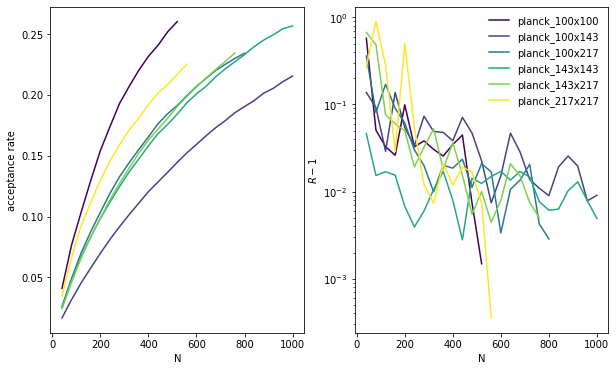

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].set_ylabel("acceptance rate")
ax[1].set_ylabel("$R-1$")
for i, (k, v) in enumerate(results.items()):
    v["progress"].plot(x="N", y="acceptance_rate", ax=ax[0], color=colors[i], legend=False)
    v["progress"].plot(x="N", y="Rminus1", ax=ax[1], color=colors[i], legend=False, logy=True)

plt.legend(results.keys());

## $\alpha$ posterior distributions

In [4]:
import numpy as np
import pandas as pd

mean_mcmc = [result["sample"].getMeans()[0] for result in results.values()]
std_mcmc = [np.sqrt(result["sample"].getVars()[0]) for result in results.values()]
#std_fisher = [result["std_fisher"] for result in results.values()]
#delta = 100 * (1 - np.array(std_mcmc) / np.array(std_fisher))

df = pd.DataFrame(
    {
        "mean MCMC": mean_mcmc,
        "std. MCMC": std_mcmc,
        r"$\mu/\sigma$": np.array(mean_mcmc)/np.array(std_mcmc)
        #"std. Fisher": std_fisher,
        #"$\Delta$ [%]": delta,
    },
    index=results.keys(),
)
df

,mean MCMC,std. MCMC,$\mu/\sigma$
planck_100x100,-0.119453,0.136617,-0.874360
planck_100x143,0.087428,0.111501,0.784099
planck_100x217,0.240448,0.132059,1.820769
planck_143x143,0.344985,0.143968,2.396258
planck_143x217,0.506323,0.157999,3.204596
planck_217x217,0.511081,0.219342,2.330061


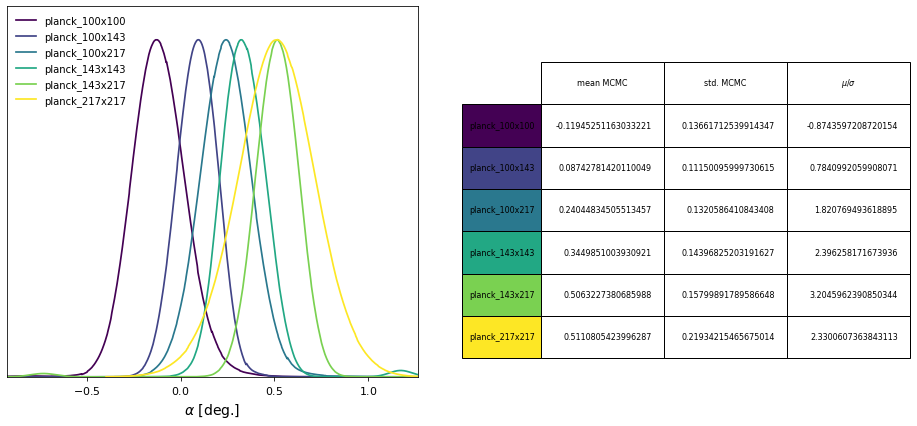

In [5]:
from getdist import plots

samples = [v["sample"] for k, v in results.items()]
line_args = [{"ls": "-", "color": colors[i]} for i in range(len(samples))]

g = plots.get_single_plotter(ratio=1, width_inch=6)
g.plot_1d(samples, "alpha", line_args=line_args)
plt.xlabel(r"$\alpha$ [deg.]")
plt.legend(results.keys())

plt.table(
    cellText=df.values,
    rowLabels=df.index,
    colLabels=df.columns,
    rowColours=colors,
    bbox=[1.3, 0.05, 0.9, 0.8],
);

## Best fit

In [9]:
from pspy import pspy_utils
import sys

sys.path.append("Planck")
import planck_utils

lmax = 3000
clfile = "./Planck/data/cosmo2017_10K_acc3_lensedCls.dat"
lth, Clth = pspy_utils.ps_lensed_theory_to_dict(
    clfile, output_type="Cl", lmax=lmax, start_at_zero=False
)


def plot_spectra(use_larger_bins=False, filename=None):
    results_file = "./chains/results_unbinned.pkl"
    binning_file = "./Planck/data/bin_planck.dat"
    mc_dir = "./Planck/montecarlo_ffp10"

    if use_larger_bins:
        results_file = "./chains/results_bin30.pkl"
        binning_file = "./Planck/data/binning_30.dat"
        mc_dir = "./Planck/montecarlo_ffp10_larger_bin"

    results = pickle.load(open(results_file, "rb"))
    mean_mcmc = [result["sample"].getMeans()[0] for result in results.values()]
    std_mcmc = [np.sqrt(result["sample"].getVars()[0]) for result in results.values()]

    lb, Cb_EE_th = planck_utils.binning(lth, Clth["EE"], binning_file=binning_file, lmax=3000)
    lb, Cb_BB_th = planck_utils.binning(lth, Clth["BB"], binning_file=binning_file, lmax=3000)

    lmin, lmax = 100, 1500
    idl = np.where((lb >= lmin) & (lb <= lmax))
    Cb_EE_th, Cb_BB_th = Cb_EE_th[idl], Cb_BB_th[idl]

    from itertools import combinations_with_replacement as cwr

    fig, axes = plt.subplots(len(results) // 2, 2, sharex=True, figsize=(16, 10))

    for i, (f0, f1) in enumerate(cwr([100, 143, 217], 2)):
        lb, Cb_EB, std_EB = np.loadtxt("%s/EB_legacy_%sx%s.dat" % (mc_dir, f0, f1), unpack=True)

        def Cb_EB_fit(alpha):
            return 1 / 2 * (Cb_EE_th - Cb_BB_th) * np.sin(4 * np.deg2rad(alpha))

        def chi2(alpha):
            return np.sum((Cb_EB - Cb_EB_fit(alpha)) ** 2 / std_EB ** 2)

        def label(alpha):
            from scipy import stats

            return r"$\chi^2$/dof($\alpha=${:.2f}°) = {:.2f}/{} - PTE = {:.2f}".format(
                alpha, chi2(alpha), len(lb), stats.chi2.sf(chi2(alpha), len(lb))
            )

        axes.flat[i].errorbar(lb, Cb_EB, std_EB, fmt=".", zorder=0, label=label(alpha=0.0))
        axes.flat[i].plot(
            lb, Cb_EB_fit(mean_mcmc[i]), "tab:red", zorder=1, label=label(alpha=mean_mcmc[i])
        )
        axes.flat[i].set_title("Planck - {}x{} GHz".format(f0, f1))
        axes.flat[i].legend()

        axes.flat[i].fill_between(
            lb,
            Cb_EB_fit(mean_mcmc[i] - std_mcmc[i]),
            Cb_EB_fit(mean_mcmc[i] + std_mcmc[i]),
            alpha=0.5,
            color="gray",
        )

    for ax in axes[-1]:
        ax.set_xlabel("$\ell$")
    axes[1, 0].set_ylabel("$D_\ell^\mathrm{EB}\;[\mu\mathrm{K}^2]$", fontsize=16)
    plt.subplots_adjust()
    if filename is not None:
        plt.savefig(filename)

## Unbinned spectra

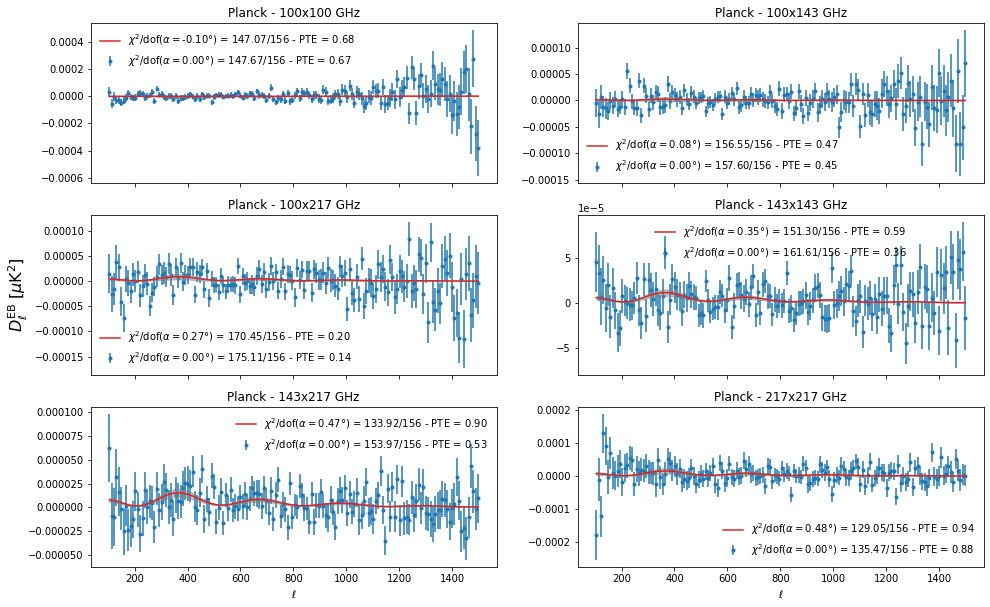

In [10]:
plot_spectra(use_larger_bins=False, filename="spectra_unbinned.png")

## Binned spectra

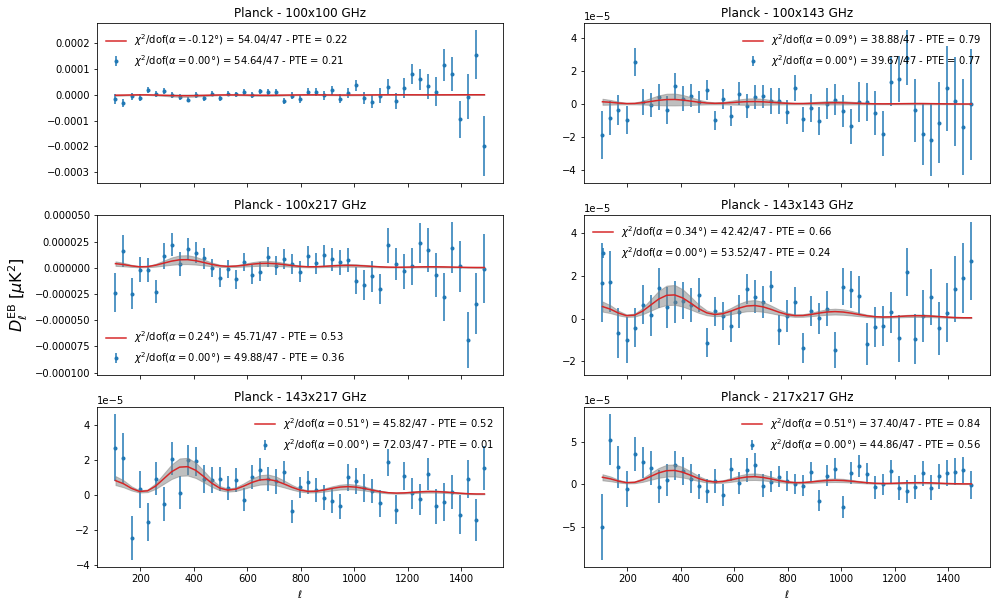

In [11]:
plot_spectra(use_larger_bins=True, filename="spectra_bin30.png")